# Prerequisites

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Subset
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm

/opt/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <EEB3232B-F6A7-3262-948C-BB2F54905803> /opt/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

# Folder to save the dataset
output_folder = "data"
os.makedirs(output_folder, exist_ok=True)

# File name for the downloaded dataset
file_name = os.path.join(output_folder, "dataset.zip")

def download_file(url, output_path):
    """Download a file from a URL and save it locally."""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"File downloaded successfully: {output_path}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

# Download the dataset
download_file(url, file_name)

In [50]:
# Extract downloaded dataset

import zipfile

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(output_folder)
print("Dataset extracted successfully.")

NameError: name 'file_name' is not defined

In [52]:
# Data path in GDrive
# data_path = "/content/drive/MyDrive/datasets/augmented-datasets/Plant_leave_diseases_dataset_with_augmentation"
# Data path local hirzi
# data_path = "J:\\tesis\ sundana\\Plant_leave_diseases_dataset_with_augmentation"
# Data path mac
data_path = "/Users/firmansyahsundana/Documents/tesis/data"

In [31]:
total_samples = 0

for folder in os.listdir(data_path):
    print(folder, len(os.listdir(os.path.join(data_path, folder))))
    total_samples += len(os.listdir(os.path.join(data_path,folder)))

print('\n')
print('Total samples =>', total_samples)

Strawberry___healthy 1000
Grape___Black_rot 1180
Potato___Early_blight 1000
Blueberry___healthy 1502
Cherry___Powdery_mildew 1052
Tomato___Target_Spot 1404
Peach___healthy 1000
Potato___Late_blight 1000
Tomato___Late_blight 1909
Tomato___Tomato_mosaic_virus 1000
Pepper,_bell___healthy 1478
Orange___Haunglongbing_(Citrus_greening) 5507
Tomato___Leaf_Mold 1000
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 1076
Apple___Cedar_apple_rust 1000
Tomato___Bacterial_spot 2127
Grape___healthy 1000
Corn___Cercospora_leaf_spot Gray_leaf_spot 1000
Tomato___Early_blight 1000
Grape___Esca_(Black_Measles) 1383
Raspberry___healthy 1000
Tomato___healthy 1591
Corn___Northern_Leaf_Blight 1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus 5357
Cherry___healthy 1000
Apple___Apple_scab 1000
Tomato___Spider_mites Two-spotted_spider_mite 1676
Corn___Common_rust 1192
Background_without_leaves 1143
Peach___Bacterial_spot 2297
Pepper,_bell___Bacterial_spot 1000
Tomato___Septoria_leaf_spot 1771
Corn___healthy 1162
Squash___P

# Dataset Preparation

In [6]:
from data_setup import create_dataloader

# Define transformations, including resizing, converting to tensor, and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (or the input size for your model)
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

train_loader, val_loader, test_loader, class_names = create_dataloader(
    data_path = data_path,
    transform = transform,
    batch_size = 64,
)

In [8]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [11]:
num_classes = len(class_names)
print("Class Names:", class_names)
print("Num. classes: ", num_classes)

Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yel

# Build Model

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### MobileNet V1

In [24]:
from models.mobilenetv1 import MobileNetV1

model_v0 = MobileNetV1(ch_in=3,n_classes=num_classes)  # Replace 1000 with the number of classes you have
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v0.parameters(), lr=0.001)

In [26]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v0.to(device)

MobileNetV1(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(1, 1

In [30]:
from torchsummary import summary

summary(model_v0, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]           2,048
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
           Conv2d-10           [-1, 64, 56, 56]             576
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]           8,192
      BatchNorm2d-14          [-1, 128,

## MobileNetV3

In [40]:
from models.mobilenetv3 import MobileNetV3

mobilenetv3 = MobileNetV3(num_classes=num_classes)
mobilenetv3.to(device)

MobileNetV3(
  (first_conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (first_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_activation): Hardswish()
  (blocks): Sequential(
    (0): MobileNetV3Block(
      (activation): ReLU()
      (depthwise_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise_conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MobileNetV3Block(
      (activation): ReLU()
      (expand_conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (depthwise_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [42]:
summary(mobilenetv3, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  MobileNetV3Block-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

## MobileNetV3 + Fire Module

# Train

In [60]:
from utils import plot_training_history, train_model

## MobileNet V1

In [ ]:
# Run training and testing
num_epochs = 10
# Train the model
train_model(model_v0, train_loader, val_loader, num_epochs)

Epoch 1/10: 100%|██████████| 169/169 [2:15:11<00:00, 48.00s/batch]


Epoch [1/10], Train Loss: 1.3897, Train Accuracy: 60.13%, Val Loss: 1.3039, Val Accuracy: 61.11%


Epoch 2/10: 100%|██████████| 169/169 [03:28<00:00,  1.23s/batch]


Epoch [2/10], Train Loss: 0.4104, Train Accuracy: 87.00%, Val Loss: 0.5476, Val Accuracy: 82.22%


Epoch 3/10: 100%|██████████| 169/169 [03:24<00:00,  1.21s/batch]


Epoch [3/10], Train Loss: 0.2143, Train Accuracy: 93.07%, Val Loss: 0.8252, Val Accuracy: 76.21%


Epoch 4/10: 100%|██████████| 169/169 [03:24<00:00,  1.21s/batch]


Epoch [4/10], Train Loss: 0.1311, Train Accuracy: 95.91%, Val Loss: 1.1333, Val Accuracy: 71.87%


Epoch 5/10: 100%|██████████| 169/169 [03:26<00:00,  1.22s/batch]


Epoch [5/10], Train Loss: 0.1025, Train Accuracy: 96.68%, Val Loss: 0.3268, Val Accuracy: 89.55%


Epoch 6/10: 100%|██████████| 169/169 [03:26<00:00,  1.22s/batch]


Epoch [6/10], Train Loss: 0.0767, Train Accuracy: 97.54%, Val Loss: 0.1387, Val Accuracy: 95.49%


Epoch 7/10: 100%|██████████| 169/169 [03:25<00:00,  1.22s/batch]


Epoch [7/10], Train Loss: 0.0497, Train Accuracy: 98.42%, Val Loss: 0.2342, Val Accuracy: 92.52%


Epoch 8/10: 100%|██████████| 169/169 [03:25<00:00,  1.21s/batch]


Epoch [8/10], Train Loss: 0.0612, Train Accuracy: 97.98%, Val Loss: 0.2673, Val Accuracy: 92.12%


Epoch 9/10: 100%|██████████| 169/169 [03:26<00:00,  1.22s/batch]


Epoch [9/10], Train Loss: 0.0480, Train Accuracy: 98.43%, Val Loss: 0.1442, Val Accuracy: 95.21%


Epoch 10/10: 100%|██████████| 169/169 [03:25<00:00,  1.22s/batch]


Epoch [10/10], Train Loss: 0.0375, Train Accuracy: 98.78%, Val Loss: 0.1454, Val Accuracy: 95.24%
Training completed in: 200m 4s


Check final loss

In [ ]:
model_v0.eval()

total_loss = 0.0
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model_v0(inputs)
    loss = criterion(outputs, labels)
    total_loss += loss.item() * inputs.size(0)

# Calculate avg loss
final_loss = total_loss / len(test_loader)
print(f"Final Loss: {final_loss:.4f}")

Final Loss: 38.4281


In [ ]:
# Save a full checkpoint with additional details
checkpoint = {
    'model_state_dict': model_v0.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # Optional if you need it
    'epoch': num_epochs,
    'loss': final_loss,  # Replace final_loss with your final loss value
}
torch.save(model_v0.state_dict(), '/content/drive/MyDrive/checkpoints/model_v0.pth')

## MobileNetV3

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3.parameters(), lr=0.001)

In [ ]:
num_epochs = 20
# Train the model
history = train_model(mobilenetv3, train_loader, val_loader, num_epochs, criterion, optimizer, device)

Epoch 1/20: 100%|██████████| 673/673 [2:59:30<00:00, 16.00s/batch]  


Epoch [1/20], Train Loss: 3.6793, Train Accuracy: 2.31%, Val Loss: 3.6827, Val Accuracy: 2.53%


Epoch 2/20: 100%|██████████| 673/673 [2:32:39<00:00, 13.61s/batch]  


Epoch [2/20], Train Loss: 3.6796, Train Accuracy: 2.37%, Val Loss: 3.6812, Val Accuracy: 2.53%


Epoch 3/20:  45%|████▌     | 304/673 [1:03:54<1:10:32, 11.47s/batch]

In [66]:

plot_training_history(history)

NameError: name 'history' is not defined

# Evaluation

In [ ]:
from utils import evaluate_model

# Access the classes from the underlying dataset
class_names = test_loader.dataset.dataset.classes
print("Class Names:", class_names)

## MobileNet V1

In [ ]:
# Load model

loaded_model_v0 = MobileNetV1(ch_in=3, n_classes=num_classes)
loaded_model_v0.load_state_dict(torch.load(f='/content/drive/MyDrive/checkpoints/model_v0.pth'))
loaded_model_v0

<ipython-input-18-1bbceb342ff1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_v0.load_state_dict(torch.load(f='/content/drive/MyDrive/checkpoints/model_v0.pt

MobileNetV1(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(1, 1

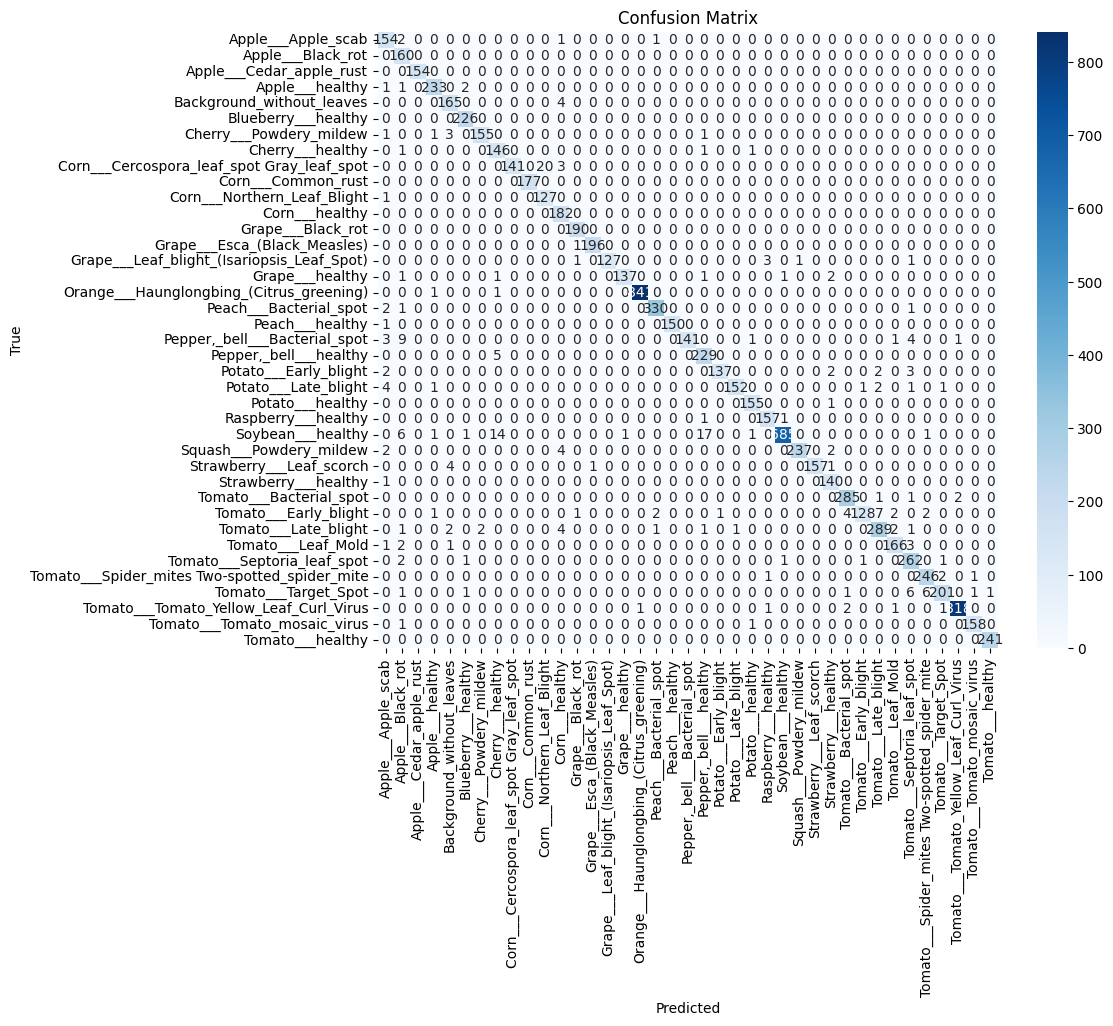

In [ ]:
cm, performance_table = evaluate_model(loaded_model_v0, test_loader, class_names)

In [ ]:
performance_table

{'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
 'Value': ['0.97', '0.97', '0.97', '0.9731']}

## MobileNet V3

In [62]:
cm, performance_table, final_loss = evaluate_model(mobilenetv3, test_loader, class_names)

NameError: name 'evaluate_model' is not defined

In [54]:
performance_table

{'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
 'Value': ['0.99', '0.99', '0.99', '0.9862']}

In [55]:
# Save a full checkpoint with additional details
checkpoint = {
    'model_state_dict': mobilenetv3.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # Optional if you need it
    'epoch': num_epochs,
    'loss': final_loss,  # Replace final_loss with your final loss value
}
torch.save(mobilenetv3.state_dict(), 'J:\\tesis\\checkpoints\\mobilenetv3.pth')